##Triage Research/Assumptions:

The graph below is from the Center for Disease Control and Prevention Morbidity and Mortality Weekly Report (MMWR). The graph aggregates median wait and treatment times by triage level in 2010 and 2011. It is important to notes that about 17% of records were excluded from this analysis due to a wide array of reasons. All assumptions made on treatment and wait times were estimated from reading the grpah below.

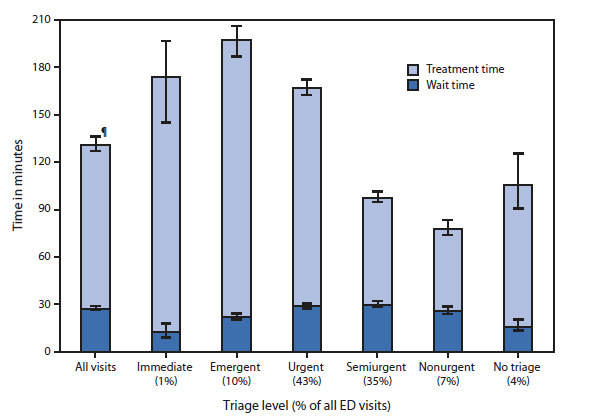

**Standard Triage 5-point scale:**

1 - immediate

2 - emergent

3 - urgent

4 - semiurgent

5 - nonurgent

**Median Wait Times:**

1 - 5 minutes

2 - 17 minutes

3 - 25 minutes

4 - 30 minutes

5 - 28 minutes

**Median Treatment Times:**

1 - 165 minutes

2 - 175 minutes

3 - 145 minutes

4 - 60 minutes

5 - 45 minutes

**Frequecy of Triage Levels:**

1 - 0.41 %

2 - 6.10 %

3 - 40.20 %

4 - 42.60 %

5 - 10.60 %

Note: The frequecy percentages above are derived from an article written in the National Library of Medicine that collected actvity data for 8 Emergency Departments in Spain. It is important to note that while this data was collected in Spain, the triage process in the US and Spain are very similar. This was chosen as the data source as it was the only research we were able to find that provided these statistics at the triage level.

##Staffing and Capacity Research/Assumptions:

Our model will simulate a mid-size hospital for 24 hours. The values below have been estimated based on a study done by the NIH on modelling attending physician productivity in the emergency department. The chart that guided majority of these estimates is showen below:

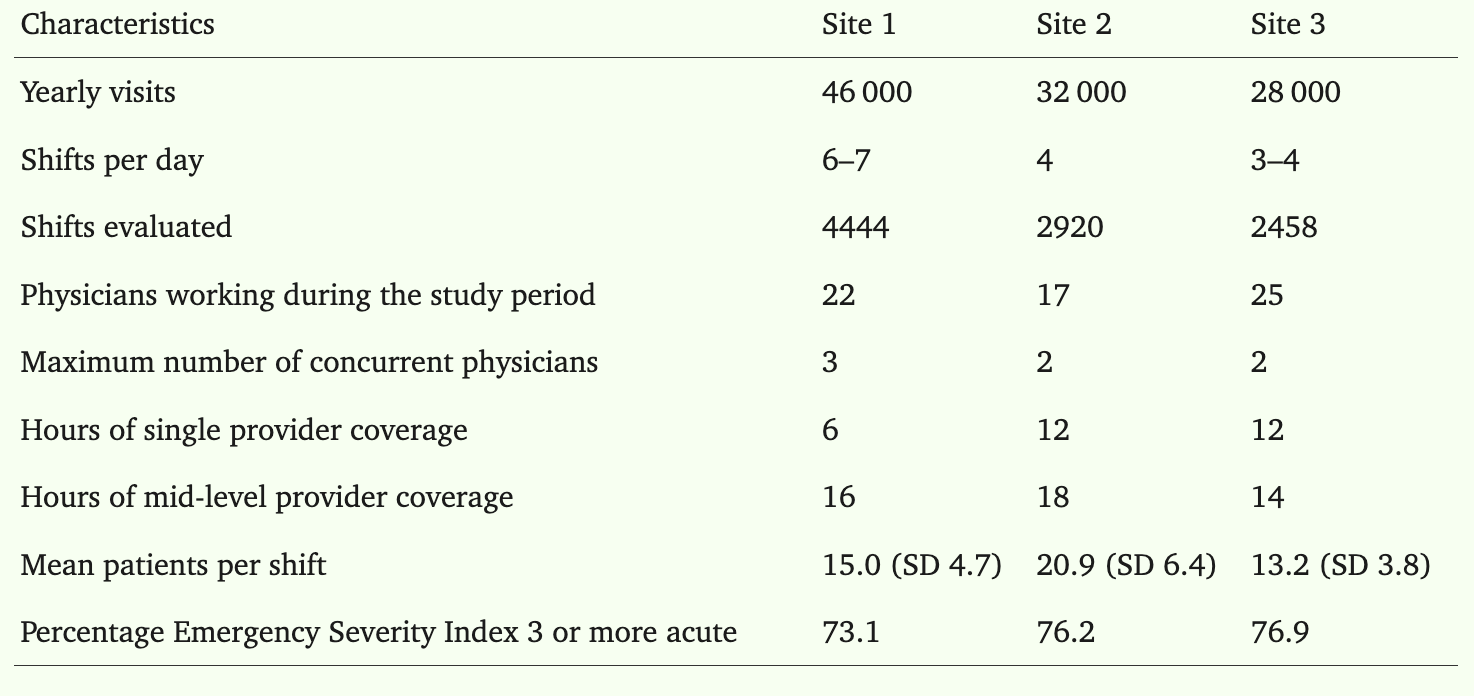

**Estimates for  Mid-Size Emergency Department with 30 - 40k annual visits:**

- 20 beds
- 2 physicians working at any given moment
- 4 patients per hour

##Import Necessary Packages

In [ ]:
import numpy as np
import heapq
import pandas as pd
import matplotlib.pyplot as plt

##Define Initial Variables

In [ ]:
#our simulation will run for 24 hours (1440 minutes)
sim_time = 1440
#define variables for all researched assumptions
lambda_rate = 4
doctors = 2
beds = 20
#keep track of availbale resources
bed_free = [0]*beds
doc_free = [0]*doctors
levels = [1,2,3,4,5]
#asuumptions made based on research above for triage specific duratoins
#wait - time to get a bed
#total treatment - entire time spend on bed
#other treatment - treated by nurses or resting
#doctor treatment - active time spent with doctor
median_triage_wait_times = [5, 17, 25, 30, 28]
median_triage_totaltreatment_times = [165, 175, 145, 60, 45]
median_triage_othertreatment_times = [140.25, 148.75, 123.25, 51.0, 38.25]
#on average doctors are only in the patient room for about 15% of the time
median_triage_doctortreatment_times = [24.75, 26.25, 21.75, 9.0, 6.75]
#distributed the missing probabilty evenly across triage levels
triage_probs = [0.00468, 0.06158, 0.42658, 0.40058, 0.10658]


Define Helper Functions:

In [ ]:
def metrics(patients):
    bed_waits = []
    doc_waits = []
    loss = []
    for p in patients:
      bed_waits.append(p['bed_wait'])
      doc_waits.append(p['doc_wait'])
      loss.append(p['bed_end'] - p['arrival'])

    return {
        "Average bed wait times:": sum(bed_waits) / len(bed_waits),
        "Average doctor wait times:": sum(doc_waits) / len(doc_waits),
        "Average length of stays:": sum(loss) / len(loss)
    }

##Model Arrivals

In [ ]:
#iterate through time and calculate the time between patient arrivals using a exponential random  distribution (poisson process)
#append arrival times by adding interarrival time to currrent time
current_time = 0
arrival_times = []
while current_time < sim_time:
  interarrival = np.random.exponential(60/lambda_rate)
  current_time = current_time + interarrival
  if current_time + interarrival < sim_time:
    arrival_times.append(current_time)

#assign triage levels and service durations based on researched triage probabilities
N = len(arrival_times)
triage = np.random.choice([1,2,3,4,5], size=N, p=triage_probs)

#find respective other treatment time and sample exponentially with the median
service = []
for i in triage:
  #draws a random sample from an exponential distribution with mean = median
  median = median_triage_othertreatment_times[i-1]
  service.append(np.random.exponential(median))

#find respective doctor treatment time and sample exponentially with the median
treatment = []
for i in triage:
  median = median_triage_doctortreatment_times[i-1]
  treatment.append(np.random.exponential(median))

##First Model: Queuing Model: M/M/k (FIFO)

**This is a Monte Carlo Simulation that follows a First-In, First-Out (FIFO) method.**

We want to understand all parts of the process including:

**bed_time** = time that patients gets a bed

**bed_wait** = time waiting for a bed

**doc_wait** = time waiting for doctor once at bed

**doc_start** = time that doctor starts

**doc_end** = time that doctor finishes

The doctor queue will follow a M/M/2 model where k = 2 (2 dcotors on staff at any given time) and the bed queue will follow a M/M/20 model where k = 20 (20 beds in the ED).

Note: We assume a 5 minute buffer for staff to take vitals and setup once a patient has gotten a bed regardless of triage level.

In [ ]:
#here patients are processed in arrival order
#single waiting line
bed_q_len = 0
doctor_q_len = 0
#instantiate a queue for bed and for doctors, hold the time and length
bed_q = []
doctor_q = []
#time when each bed is open
bed_open = [0]*beds
doctor_open = [0]*doctors

#instantiate patient records
patients = []
for i in range(len(arrival_times)):
    patient = {}
    patient['arrival'] = arrival_times[i]
    patient['triage'] = triage[i]
    patient['treatment'] = treatment[i] #total treatment time with doc
    patient['other_service'] = service[i] #total time being serviced once you have bed
    patient['bed_wait'] = None
    patient['doc_wait'] = None
    patient['doc_start'] = None
    patient['doc_end'] = None
    patients.append(patient)

for patient in patients:
  arrival = patient["arrival"]
  #sequentially assign next bed open by arrival order
  next_bed = min(bed_open)

  #if a bed is available immediatley
  if next_bed <= arrival:
    bed_index = bed_open.index(next_bed)
    patient['bed_start'] = arrival
    #they did not have to wait
    patient['bed_wait'] = 0
  else:
    #increment the queue beceause patient had to wait
    bed_q_len = bed_q_len + 1
    bed_index = bed_open.index(next_bed)
    patient['bed_start'] = next_bed
    patient['bed_wait'] = next_bed - arrival

  bed_q.append((arrival, bed_q_len))
  #patient only stops using bed when other service, treatment time, and 5 minutes of buffer are complete
  patient['bed_end'] = patient['bed_start'] + patient['other_service'] + patient['treatment']+ 5
  bed_open[bed_index] = patient['bed_end']

  ready_time = patient['bed_start'] + patient['other_service'] + 5
  next_doctor = min(doctor_open)
  if next_doctor <= ready_time:
    #doctor is available immediate
    doctor_index = doctor_open.index(next_doctor)
    patient['doc_start'] = ready_time
    patient['doc_wait'] = 0
  else:
    doctor_q_len = doctor_q_len + 1
    doctor_index = doctor_open.index(next_doctor)
    patient['doc_start'] = next_doctor
    patient['doc_wait'] = next_doctor - ready_time


  doctor_q.append((ready_time, doctor_q_len))
  patient['doc_end'] = patient['bed_start'] + patient['other_service'] + patient['treatment']+ 5
  doctor_open[doctor_index] = patient['doc_end']


## 24hr Simulation Model Results

In [ ]:
bed_total = []
bed_waits = []
total_stay = []
m = metrics(patients)

print("Average bed wait time:", m["Average bed wait times:"])
print("Average doctor wait time:", m["Average doctor wait times:"])
print("Average length of stay:", m["Average length of stays:"])

simulation_end = 0
for p in patients:
  if p['doc_end'] > simulation_end:
    simulation_end = p['doc_end']

percent_beds_in_use = sum(bed_open) / (beds * simulation_end)
print("Bed utilization:", percent_beds_in_use)

doctor_utilization = sum(doctor_open) / (doctors * simulation_end)
print("Doctor utilization:", doctor_utilization)

Average bed wait time: 0.0
Average doctor wait time: 27.764858546895912
Average length of stay: 96.36935790858367
Bed utilization: 0.804413378243368
Doctor utilization: 0.9253496820243965


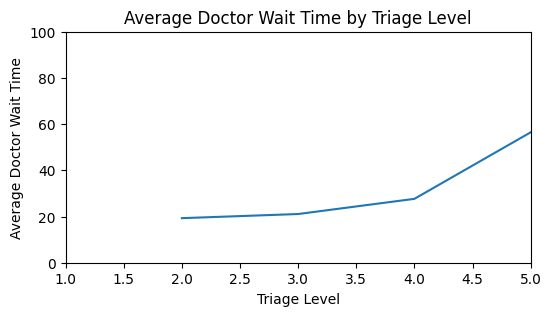

In [ ]:
r = []
for p in patients:
    r.append({"triage": p["triage"],"doc_wait": p["doc_wait"]})

df_plot = pd.DataFrame(r)

#by triage level and calculate mean doctor wait
avg_doc_wait = df_plot.groupby("triage")["doc_wait"].mean().reset_index()

plt.figure(figsize=(6,3))
plt.plot(avg_doc_wait["triage"], avg_doc_wait["doc_wait"])
plt.xlabel("Triage Level")
plt.ylabel("Average Doctor Wait Time")
plt.title("Average Doctor Wait Time by Triage Level")
plt.xlim(1, 5)
plt.ylim(0, 100)
plt.show()

##2nd Model: Queuing Model: Incorporate Triage Priorities
This model will use the same methodology and assumptions as before, but now bed assignment is priority-based rather than first in first out.

In [ ]:
#single waiting line
bed_q_len = 0
doctor_q_len = 0
#waiting lines for each traige level
bed_q = {1:[], 2:[], 3:[], 4:[], 5:[]}
doctor_q = []
bed_open = [0]*beds
doctor_open = [0]*doctors
bed_q_list =[]
patients = []
for i in range(len(arrival_times)):
    patient = {}
    patient['arrival'] = arrival_times[i]
    patient['triage'] = triage[i]
    patient['treatment'] = treatment[i] #total treatment time with doc
    patient['other_service'] = service[i] #total time being serviced once you have bed
    patient['bed_time'] = None
    patient['bed_wait'] = None
    patient['doc_wait'] = None
    patient['doc_start'] = None
    patient['doc_end'] = None
    patients.append(patient)

for patient in patients:
  arrival = patient["arrival"]
  #create array for free beds
  free_beds = []
  for bed_index in range(len(bed_open)):
    bed_free_time = bed_open[bed_index]
    #if bed becomes free before the current arrival time
    if bed_free_time <= arrival:
        free_beds.append((bed_free_time, bed_index))
  free_beds.sort()

  #as long there is a free bed give it to a patient who is waiting
  while free_beds:
    # find highest-priority waiting patient
    urgent = None
    for t in levels:
      if bed_q[t]:
        #removed the patient that has been waiting the longest
        urgent = bed_q[t].pop(0)
        break
    if urgent is None:
      break

    bed_free_time, bed_i = free_beds.pop(0)

    # bed starts
    urgent['bed_start'] = bed_free_time
    urgent['bed_wait']  = urgent['bed_start'] - urgent['arrival']

    # doctor begins
    ready_time = urgent['bed_start']
    next_doctor = min(doctor_open)
    doctor_index = doctor_open.index(next_doctor)
    urgent['doc_start'] = max(ready_time, next_doctor)
    urgent['doc_wait']  = urgent['doc_start'] - ready_time
    urgent['doc_end']   = urgent['doc_start'] + urgent['treatment']
    doctor_open[doctor_index] = urgent['doc_end']

    urgent['bed_end'] = urgent['bed_start'] + urgent['other_service'] + 5 + urgent['treatment']
    bed_open[bed_i] = urgent['bed_end']

    if bed_open[bed_i] <= arrival:
      free_beds.append((bed_open[bed_i], bed_i))
      free_beds.sort()

  tri = patient['triage']
  next_bed = min(bed_open)

  if next_bed <= arrival:
    bed_index = bed_open.index(next_bed)
    patient['bed_start'] = arrival
    patient['bed_wait']  = 0

    # doctor can start once in bed
    ready_time = patient['bed_start']
    next_doctor = min(doctor_open)
    doctor_index = doctor_open.index(next_doctor)
    patient['doc_start'] = max(ready_time, next_doctor)
    patient['doc_wait']  = patient['doc_start'] - ready_time
    patient['doc_end']   = patient['doc_start'] + patient['treatment']
    doctor_open[doctor_index] = patient['doc_end']
    patient['bed_end'] = max(patient['bed_start'] + patient['other_service'] + 5, patient['doc_end'])
    bed_open[bed_index] = patient['bed_end']
  else:
    # no bed yet
    bed_q[tri].append(patient)

  total_waiting = sum(len(bed_q[t]) for t in bed_q)
  bed_q_list.append((arrival, total_waiting))


In [ ]:
m = metrics(patients)

print("Average bed wait time:", m["Average bed wait times:"])
print("Average doctor wait time:", m["Average doctor wait times:"])
print("Average length of stay:", m["Average length of stays:"])

Average bed wait time: 0.0
Average doctor wait time: 6.891635531336027
Average length of stay: 83.638664366713


##Monte Carlo Simulation

The operational goal of a Monte Carlo simulation is to compute E(f(Y)) efficiently and accurately enough. In this simulation, we can let Y represent the stochastic inputs in the Emergency Department: arrival times, treatment times, triage level, etc. f(Y) will be obtained via the performance metrics like average doctor wait time output at the end of the model. By the Law of Large Numbers, more replications the sample mean of LOS, bed wait time, and doctor wait time will converge.

In [ ]:
#same logic as above, run 50 times and store
num_runs = 50
all_patients = []
all_beds = []

for run in range(num_runs):
    #calculte new original variables for every run
    current_time = 0
    arrival_times = []
    while current_time < sim_time:
      interarrival = np.random.exponential(60/lambda_rate)
      current_time = current_time + interarrival
      if current_time + interarrival < sim_time:
        arrival_times.append(current_time)

    N = len(arrival_times)
    triage = np.random.choice([1,2,3,4,5], size=N, p=triage_probs)


    service = []
    for i in triage:
      median = median_triage_othertreatment_times[i-1]
      service.append(np.random.exponential(median))

    treatment = []
    for i in triage:
      median = median_triage_doctortreatment_times[i-1]
      treatment.append(np.random.exponential(median))
    bed_q = {1:[], 2:[], 3:[], 4:[], 5:[]}
    doctor_q = []
    bed_open = [0]*beds
    doctor_open = [0]*doctors
    bed_q_list = []

    patients = []
    for i in range(len(arrival_times)):
        patient = {}
        patient['arrival'] = arrival_times[i]
        patient['triage'] = triage[i]
        patient['treatment'] = treatment[i]
        patient['other_service'] = service[i]
        patient['bed_time'] = None
        patient['bed_wait'] = None
        patient['doc_wait'] = None
        patient['doc_start'] = None
        patient['doc_end'] = None
        patients.append(patient)
    for patient in patients:
        arrival = patient["arrival"]
        free_beds = []
        for bed_index in range(len(bed_open)):
            bed_free_time = bed_open[bed_index]
            if bed_free_time <= arrival:
                free_beds.append((bed_free_time, bed_index))
        free_beds.sort()
        while free_beds:
            urgent = None
            for t in levels:
                if bed_q[t]:
                    urgent = bed_q[t].pop(0)
                    break
            if urgent is None:
                break

            bed_free_time, bed_i = free_beds.pop(0)

            urgent['bed_start'] = bed_free_time
            urgent['bed_wait'] = urgent['bed_start'] - urgent['arrival']

            ready_time = urgent['bed_start']
            next_doctor = min(doctor_open)
            doctor_index = doctor_open.index(next_doctor)

            urgent['doc_start'] = max(ready_time, next_doctor)
            urgent['doc_wait'] = urgent['doc_start'] - ready_time
            urgent['doc_end'] = urgent['doc_start'] + urgent['treatment']
            doctor_open[doctor_index] = urgent['doc_end']

            urgent['bed_end'] = (urgent['bed_start']+ urgent['other_service']+ 5+ urgent['treatment'])
            bed_open[bed_i] = urgent['bed_end']

            if bed_open[bed_i] <= arrival:
                free_beds.append((bed_open[bed_i], bed_i))
                free_beds.sort()

        tri = patient['triage']
        next_bed = min(bed_open)
        if next_bed <= arrival:
            bed_index = bed_open.index(next_bed)
            patient['bed_start'] = arrival
            patient['bed_wait'] = 0

            ready_time = patient['bed_start']
            next_doctor = min(doctor_open)
            doctor_index = doctor_open.index(next_doctor)

            patient['doc_start'] = max(ready_time, next_doctor)
            patient['doc_wait'] = patient['doc_start'] - ready_time
            patient['doc_end'] = patient['doc_start'] + patient['treatment']
            doctor_open[doctor_index] = patient['doc_end']

            patient['bed_end'] = max(
                patient['bed_start'] + patient['other_service'] + 5,
                patient['doc_end']
            )
            bed_open[bed_index] = patient['bed_end']
        else:
            bed_q[tri].append(patient)

        total_waiting = sum(len(bed_q[t]) for t in bed_q)
        bed_q_list.append((arrival, total_waiting))

    all_patients.append(patients)
    all_beds.append(bed_q_list)


In [ ]:
avg_bed_waits = []
avg_doc_waits = []
avg_stays = []
bed_u = []
doc_u = []


for run_patients in all_patients:

    done = []
    for p in run_patients:
        if p['doc_end'] is not None:
            done.append(p)

    if len(done) == 0:
        continue

    bed_waits = []
    doc_waits = []
    stays = []

    bed_busy_time = 0
    doc_busy_time = 0
    sim_end = 0

    for p in done:
        bed_waits.append(p['bed_wait'])
        doc_waits.append(p['doc_wait'])
        # length of stay
        arrival = p['arrival']
        departure = p['bed_end']
        stays.append(departure - arrival)

        bed_busy_time += (p['bed_end'] - p['bed_start'])
        doc_busy_time += p['treatment']
        if p['bed_end'] > sim_end:
            sim_end = p['bed_end']

    # averages for this run
    avg_bed_waits.append(sum(bed_waits) / len(bed_waits))
    avg_doc_waits.append(sum(doc_waits) / len(doc_waits))
    avg_stays.append(sum(stays) / len(stays))
    bed_u.append(bed_busy_time / (beds * sim_end))
    doc_u.append(doc_busy_time / (doctors * sim_end))

mc_bed_u = sum(bed_u)/len(bed_u)
mc_doc_u = sum(doc_u)/len(doc_u)
overall_avg_bed_wait = sum(avg_bed_waits) / len(avg_bed_waits)
overall_avg_doc_wait = sum(avg_doc_waits) / len(avg_doc_waits)
overall_avg_stay = sum(avg_stays) / len(avg_stays)

print("Monte Carlo (50 runs) average bed wait time:", overall_avg_bed_wait)
print("Monte Carlo (50 runs)  average doctor wait time:", overall_avg_doc_wait)
print("Monte Carlo (50 runs)  average length of stay:", overall_avg_stay)
print("Monte Carlo (50 runs)  average doctor utilization:", mc_doc_u)
print("Monte Carlo (50 runs)  average bed utlization:", mc_bed_u)


Monte Carlo (50 runs) average bed wait time: 0.0
Monte Carlo (50 runs)  average doctor wait time: 6.526935002697744
Monte Carlo (50 runs)  average length of stay: 96.8133771190524
Monte Carlo (50 runs)  average doctor utilization: 0.4452547598210208
Monte Carlo (50 runs)  average bed utlization: 0.2800972325261065


/tmp/ipython-input-4025696060.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([avg_bed_waits, avg_doc_waits, bed_u, doc_u],


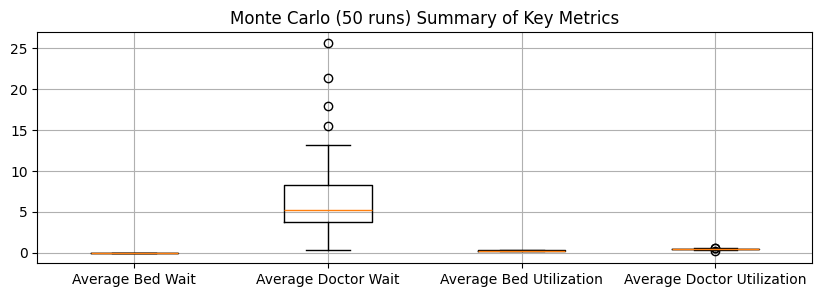

In [ ]:
plt.figure(figsize=(10,3))
plt.boxplot([avg_bed_waits, avg_doc_waits, bed_u, doc_u],
            labels=["Average Bed Wait", "Average Doctor Wait", "Average Bed Utilization", "Average Doctor Utilization"])
plt.title("Monte Carlo (50 runs) Summary of Key Metrics")
plt.grid()
plt.show()

##3rd Model: Model Changes in Capacity
First Test: Hospital may have 4 doctors in the ED during the day but only 1 at night.


*   9 am - 9 pm (Day Shift)
*   9 pm - 9 am (Night Shift)
* total of 5 doctors that only work one of these shifts

Once initial model is complete, create a function that allows you to modify the number of doctors in each shift and look for lowest wait time.



In [ ]:
def capcacity_simulation(am_docs, pm_docs):
  #single waiting line
  bed_q_len = 0
  doctor_q_len = 0
  #waiting lines for each traige level
  bed_q = {1:[], 2:[], 3:[], 4:[], 5:[]}
  doctor_q = []
  bed_open = [0]*beds
  doctor_open = [0]*max(am_docs, pm_docs)
  bed_q_list =[]
  patients = []
  am_start = 540
  am_end = 1260
  night_start = am_end
  night_end = am_start
  for i in range(len(arrival_times)):
      patient = {}
      patient['arrival'] = arrival_times[i]
      patient['triage'] = triage[i]
      patient['treatment'] = treatment[i] #total treatment time with doc
      patient['other_service'] = service[i] #total time being serviced once you have bed
      patient['bed_time'] = None
      patient['bed_wait'] = None
      patient['doc_wait'] = None
      patient['doc_start'] = None
      patient['doc_end'] = None
      patients.append(patient)

  for patient in patients:
    arrival = patient["arrival"]
    #create array for free beds
    free_beds = []
    for bed_index in range(len(bed_open)):
      bed_free_time = bed_open[bed_index]
      #if bed becomes free before the current arrival time
      if bed_free_time <= arrival:
          free_beds.append((bed_free_time, bed_index))
    free_beds.sort()

    #as long there is a free bed give it to a patient who is waiting
    while free_beds:
      # find highest-priority waiting patient
      urgent = None
      for t in levels:
        if bed_q[t]:
          #removed the patient that has been waiting the longest
          urgent = bed_q[t].pop(0)
          break
      if urgent is None:
        break

      bed_free_time, bed_i = free_beds.pop(0)

      # bed starts
      urgent['bed_start'] = bed_free_time
      urgent['bed_wait']  = urgent['bed_start'] - urgent['arrival']

      # doctor begins
      ready_time = urgent['bed_start']
      if am_start <= ready_time < am_end:
          present = list(range(am_docs))
      else:
          present = list(range(pm_docs))

      selected_doc = present[0]
      for doc in present:
          if doctor_open[doc] < doctor_open[selected_doc]:
              selected_doc = doc
      next_doctor = min(doctor_open)
      doctor_index = doctor_open.index(next_doctor)
      urgent['doc_start'] = max(ready_time, next_doctor)
      urgent['doc_wait']  = urgent['doc_start'] - ready_time
      urgent['doc_end']   = urgent['doc_start'] + urgent['treatment']
      doctor_open[doctor_index] = urgent['doc_end']

      urgent['bed_end'] = urgent['bed_start'] + urgent['other_service'] + 5 + urgent['treatment']
      bed_open[bed_i] = urgent['bed_end']

      if bed_open[bed_i] <= arrival:
        free_beds.append((bed_open[bed_i], bed_i))
        free_beds.sort()

    tri = patient['triage']
    next_bed = min(bed_open)

    if next_bed <= arrival:
        bed_index = bed_open.index(next_bed)
        patient['bed_start'] = arrival
        patient['bed_wait'] = 0

        ready_time = patient['bed_start']

        if am_start <= ready_time < am_end:
            present = list(range(am_docs))
        else:
            present = list(range(pm_docs))

        #pick the doctor that will be free the soonest
        selected_doc = present[0]
        for doc in present:
          if doctor_open[doc] < doctor_open[selected_doc]:
            selected_doc = doc
        next_doctor = doctor_open[selected_doc]

        patient['doc_start'] = max(ready_time, next_doctor)
        patient['doc_wait'] = patient['doc_start'] - ready_time
        patient['doc_end'] = patient['doc_start'] + patient['treatment']
        doctor_open[selected_doc] = patient['doc_end']

        patient['bed_end'] = max(
            patient['bed_start'] + patient['other_service'] + 5,
            patient['doc_end']
        )
        bed_open[bed_index] = patient['bed_end']
    else:
        bed_q[tri].append(patient)

    total_waiting = sum(len(bed_q[t]) for t in bed_q)
    bed_q_list.append((arrival, total_waiting))

  return patients, bed_q_list

In [ ]:
summary = []
doctor_splits = [(1, 4), (2, 3), (3, 2), (4, 1)]
for am_docs, pm_docs in doctor_splits:
    patients, x = capcacity_simulation(am_docs, pm_docs)

    m = metrics(patients)
    summary.append({
        "day_docs": am_docs,
        "night_docs": pm_docs,
        "avg_bed_wait": m["Average bed wait times:"],
        "avg_doc_wait": m["Average doctor wait times:"],
        "avg_los": m["Average length of stays:"]})
for s in summary:
    print("AM Doctors:", s["day_docs"], "PM Doctors:", s["night_docs"])
    print("Average bed wait time:", s["avg_bed_wait"])
    print("Avg doctor wait time:", s["avg_doc_wait"])
    print("Avg total length of stay:", s["avg_los"])


AM Doctors: 1 PM Doctors: 4
Average bed wait time: 0.0
Avg doctor wait time: 16.73351678507658
Avg total length of stay: 91.31133006552443
AM Doctors: 2 PM Doctors: 3
Average bed wait time: 0.0
Avg doctor wait time: 3.386934501007737
Avg total length of stay: 82.9663909627523
AM Doctors: 3 PM Doctors: 2
Average bed wait time: 0.0
Avg doctor wait time: 2.830872243303433
Avg total length of stay: 82.84829557355783
AM Doctors: 4 PM Doctors: 1
Average bed wait time: 0.0
Avg doctor wait time: 60.52294325544082
Avg total length of stay: 121.60077466128783


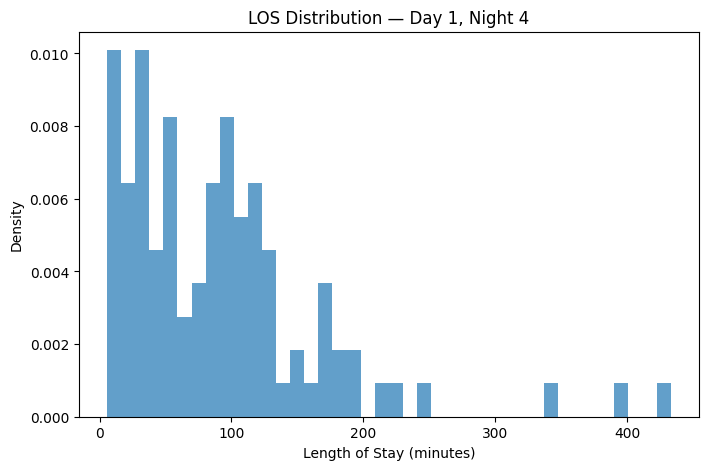

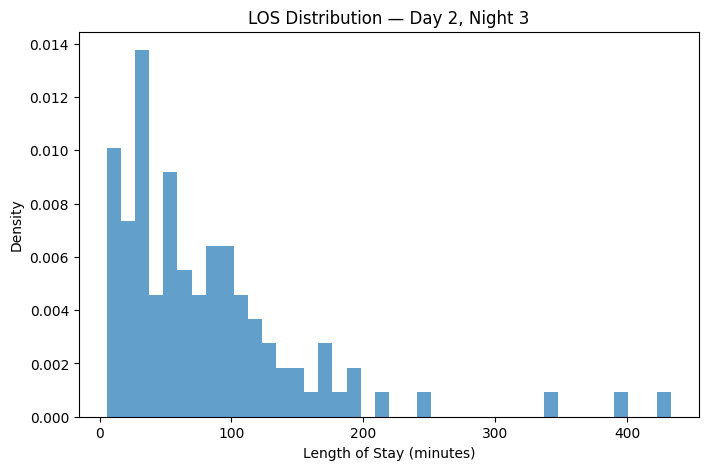

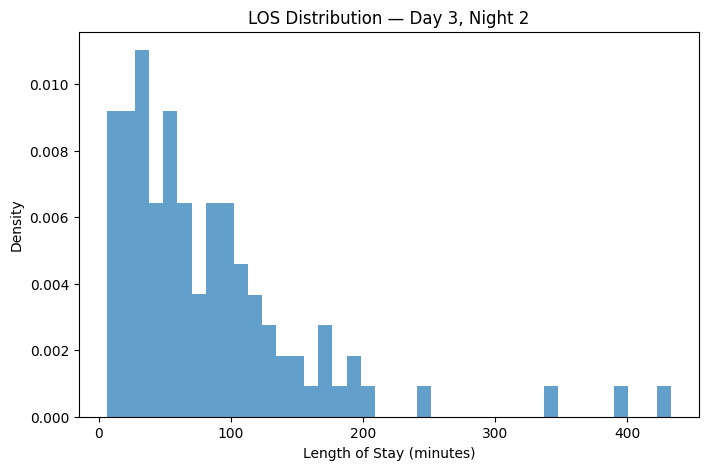

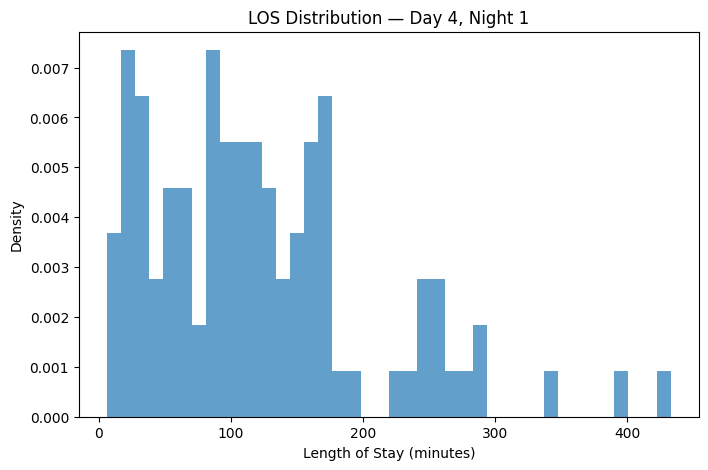

In [ ]:
los_by_case = {}
for am_docs, pm_docs in doctor_splits:
    patients, x = capcacity_simulation(am_docs, pm_docs)
    los = []
    arrival_times_plot = []
    doc_waits_plot = []
    for p in patients:
        if p['doc_end'] is not None:
            los.append(p['bed_end'] - p['arrival'])
            arrival_times_plot.append(p['arrival'])
            doc_waits_plot.append(p['doc_wait'])
    los_by_case[(am_docs, pm_docs)] = los
for (am_docs, pm_docs), los in los_by_case.items():

    plt.figure(figsize=(8,5))
    plt.hist(los, bins=40, density=True, alpha=0.7)

    plt.xlabel("Length of Stay (minutes)")
    plt.ylabel("Density")
    plt.title(f"LOS Distribution — Day {am_docs}, Night {pm_docs}")

    plt.show()



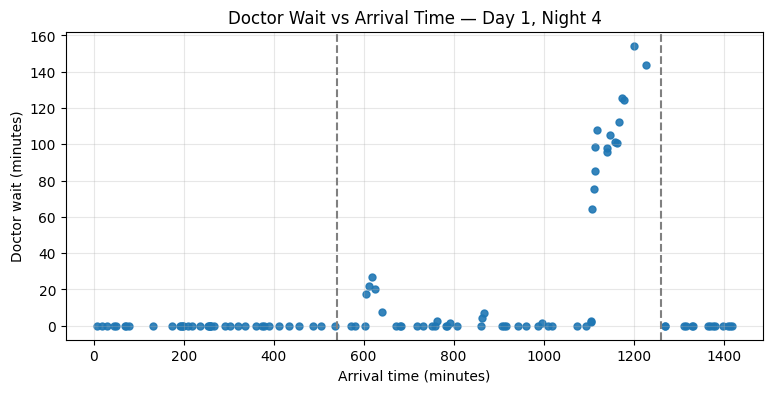

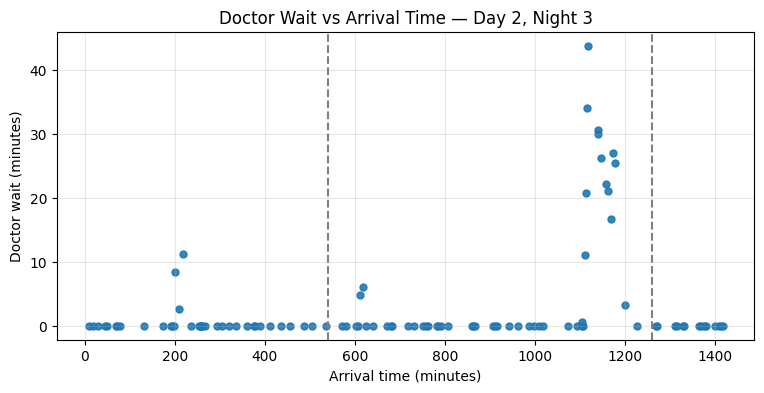

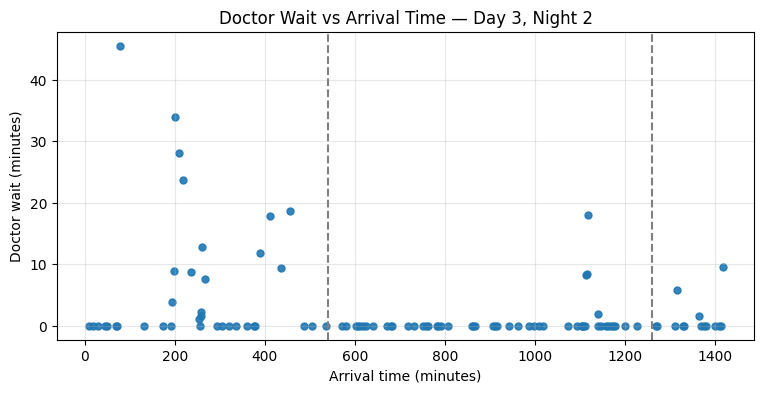

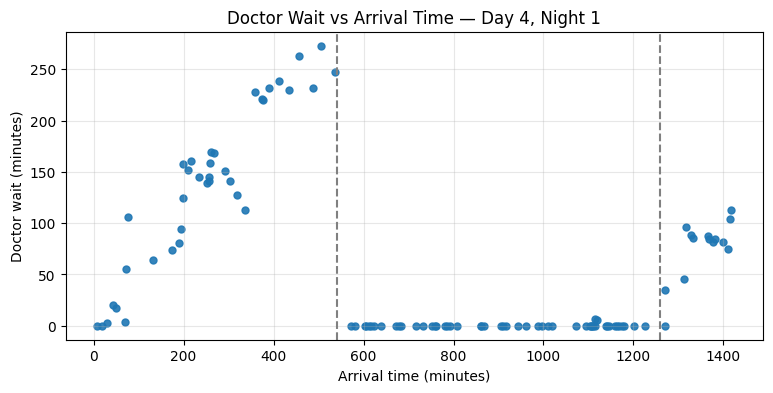

In [ ]:
for (am_docs, pm_docs) in doctor_splits:

    patients, x = capcacity_simulation(am_docs, pm_docs)
    arrival_times_plot = []
    doc_waits_plot = []

    for p in patients:
        if p['doc_end'] is not None:
            arrival_times_plot.append(p['arrival'])
            doc_waits_plot.append(p['doc_wait'])

    plt.figure(figsize=(9,4))
    plt.scatter(arrival_times_plot,doc_waits_plot,alpha=0.9,s=25)
    plt.axvline(540, linestyle="--", color="gray", label="Shift change")
    plt.axvline(1260, linestyle="--", color="gray")

    plt.xlabel("Arrival time (minutes)")
    plt.ylabel("Doctor wait (minutes)")
    plt.title(f"Doctor Wait vs Arrival Time — Day {am_docs}, Night {pm_docs}")
    plt.grid(alpha=0.3)

    plt.show()



**The optimal solution is 3 doctors during day shift and 2 doctors during night shift.**

Sources:

https://www.cdc.gov/mmwr/preview/mmwrhtml/mm6319a8.htm

https://pmc.ncbi.nlm.nih.gov/articles/PMC11810484/#:~:text=Results,4%20and%205%20remained%20stable.

https://pmc.ncbi.nlm.nih.gov/articles/PMC5916102/#:~:text=The%20study%20setting%20was%20three,set%20plan%20for%20their%20disposition.

https://www.sciencedirect.com/science/article/abs/pii/S0002934318302961#:~:text=Results,%2C%20respiratory%20therapists%2C%20pharmacists).